In [1]:
%matplotlib inline
import network.network as Network
import pickle
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [4]:
tr_d = (X_train, y_train)
te_d = (X_test, y_test)
training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
training_results = [vectorized_result(y) for y in tr_d[1]]
training_data = (training_inputs, training_results)
test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
test_results = [vectorized_result(y) for y in te_d[1]]
test_data = (test_inputs, test_results)

In [143]:
test_inputs[0]

array([[  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
      

In [144]:
X_test[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [5]:
infile = open("train", "rb")
training_data = np.load(infile, encoding='latin1')
infile.close()

infile2 = open("test", "rb")
test_data = np.load(infile2, encoding='latin1')
infile2.close()

In [6]:
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

Network output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

Network prediction: 8

Actual image: 


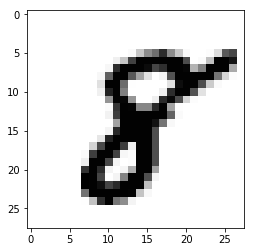

In [7]:
def predict(n):
    # Get the data from the test set
    x = test_data[n][0]
    # x = test_inputs[n]

    # Print the prediction of the network
    print('Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n')
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')
    
    # Draw the image
    plt.imshow(x.reshape((28,28)), cmap='Greys')

# Replace the argument with any number between 0 and 9999
predict(8384)

In [8]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

def adversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x
        x -= eta * d
        
    return x

# Wrapper function
def generate(n):
    """
    n : integer
        goal label (not a one hot vector)
    """
    # a = adversarial(net, n, 1000, 1)
    a = adversarial(net, n, 1000, 0.15)
    x = np.round(net.feedforward(a), 2)
    
    print('Network Output: \n' + str(x) + '\n')
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Adversarial Example: ')
    plt.imshow(a.reshape(28,28), cmap='Greys')

Network Output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Network Prediction: 0

Adversarial Example: 


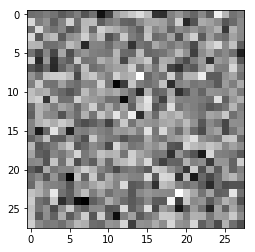

In [9]:
generate(1)

In [37]:
def sneaky_adversarial(net, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        x -= eta * (d + lam * (x - x_target))

    return x

# Wrapper function
def sneaky_generate(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while test_data[idx][1] != m:
        idx += 1
#     while y_test[idx] != m:
#         idx += 1
    
    # Hardcode the parameters for the wrapper function
    # net, n, x_target, steps, eta, lam=.05
    a = sneaky_adversarial(net, n, test_data[idx][0], 1000, 0.1, lam=0.1)
    # a = sneaky_adversarial(net, n, test_inputs[idx], 1000, 0.01, lam=5)
    x = np.round(net.feedforward(a), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_data[idx][0].reshape((28,28)), cmap='Greys')
    # plt.imshow(test_inputs[idx].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a


What we want our adversarial example to look like: 


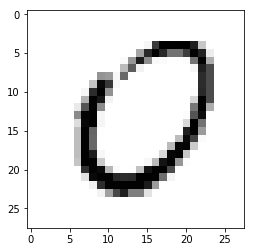



Adversarial Example: 


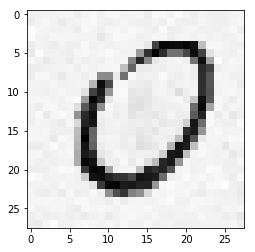

Network Prediction: 8

Network Output: 
[[0.03]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.96]
 [0.  ]]



In [97]:
adv_ex = sneaky_generate(8, 0)

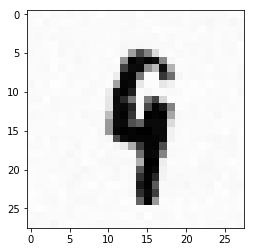

In [95]:
plt.imshow(adv_ex.reshape(28,28), cmap='Greys')
plt.show()

In [98]:
num = np.array(adv_ex)
outfile = open("actual_0_pred_8", "wb")
np.save(outfile, num)

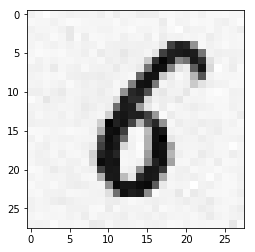

In [47]:
infile = open("actual_5_pred_9", "rb")
pic = np.load(infile)
infile.close()

plt.imshow(pic.reshape(28,28), cmap='Greys')
plt.show()